# Explorar acesso ao kafka

In [1]:
!pip install --quiet azure-storage-blob delta

In [2]:
import sys
import requests
import time
import os
import pyspark
import seaborn as sns
import matplotlib.pyplot as plt
import socket

from azure.storage.blob import BlobClient
from delta import *
from os import path
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StringType, DateType, StructType, StructField
from pyspark.sql.avro.functions import *

In [3]:
spark = (SparkSession.builder
    .appName("ExploreKafka")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")         
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

In [4]:
bootstrap = "nemesys-stream-101-kafka-external-bootstrap.nemesys-stream-101.svc:9094"
offset = "earliest"
topico = "stocks.StockData.stocks"
SCHEMA_REGISTRY = "http://nemesys-sr-schema-registry-headless.nemesys-stream-101.svc:8081"

In [5]:
# retrieve the latest schema
url = '{}/subjects/{}-value/versions/latest/schema'.format(SCHEMA_REGISTRY, topico)
# print(url)
response = requests.get(url)
# error check
response.raise_for_status()
# extract the schema from the response
schema = response.text

In [6]:
schema

'{"type":"record","name":"stocks","namespace":"stocks.StockData","fields":[{"name":"_id","type":["null","string"],"default":null},{"name":"ticker","type":["null","string"],"default":null},{"name":"description","type":["null","string"],"default":null},{"name":"timestamp","type":["null",{"type":"long","connect.version":1,"connect.name":"org.apache.kafka.connect.data.Timestamp","logicalType":"timestamp-millis"}],"default":null},{"name":"open","type":["null","double"],"default":null},{"name":"high","type":["null","double"],"default":null},{"name":"low","type":["null","double"],"default":null},{"name":"close","type":["null","double"],"default":null},{"name":"volume","type":["null","int"],"default":null},{"name":"__op","type":["null","string"],"default":null},{"name":"__collection","type":["null","string"],"default":null},{"name":"__ts_ms","type":["null","long"],"default":null}],"connect.name":"stocks.StockData.stocks"}'

In [7]:
# (spark
#     .readStream
#     .format("kafka")
#     .option("kafka.bootstrap.servers", bootstrap)
#     .option("subscribe", topico)
#     .option("startingOffsets", offset)
#     .option("security.protocol", "SSL")
#     .load()
#     .selectExpr("substring(value, 6) as avro_value")
#     .select(from_avro(col("avro_value"), schema).alias("value"))
#     .select("value.*")
#     .writeStream
#     .format('delta')
#     .outputMode('append')
#     .option('mergeSchema', 'true')
#     .option('checkpointLocation', "lakehouse/checkpoint/stocks")
#     .trigger(once=True)
#     .start("lakehouse/stocks")
#     .awaitTermination()
# )
    

In [8]:
# df = (
#     spark
#     .read
#     .format("delta")
#     .load("lakehouse/stocks")
# )

In [9]:
df2 = (spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", bootstrap)
    .option("subscribe", topico)
    .option("startingOffsets", offset)
    .option("security.protocol", "SSL")
    .load()
    .selectExpr("substring(value, 6) as avro_value")
    .select(from_avro(col("avro_value"), schema).alias("value"))
    .select("value.*")       
)
df2.createOrReplaceTempView("stocks")

In [10]:
%%sql_display
select * from stocks order by timestamp desc

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,_id,ticker,description,timestamp,open,high,low,close,volume,__op,__collection,__ts_ms
0,664f4fdd48d0478aca1cdcae,AAPL,Apple Inc.,2024-05-23 14:15:00,188.934998,188.934998,188.815002,188.899994,1953,c,stocks,1716473835762
1,664f4fdd48d0478aca1cdcb0,GOOG,Alphabet Inc.,2024-05-23 14:15:00,177.929993,177.929993,177.929993,177.929993,109,c,stocks,1716473835763
2,664f4fde48d0478aca1cdcb2,MSFT,Microsoft Corporation,2024-05-23 14:15:00,431.660004,431.679993,431.625000,431.660004,905,c,stocks,1716473835763
3,664f4fde48d0478aca1cdcb4,TSLA,"Tesla, Inc.",2024-05-23 14:15:00,177.470001,177.500000,177.240005,177.500000,864,c,stocks,1716473835763
4,664f4fde48d0478aca1cdcb6,AMZN,"Amazon.com, Inc.",2024-05-23 14:15:00,182.919998,182.990005,182.839996,182.934998,2373,c,stocks,1716473835763
5,664f4fde48d0478aca1cdcb8,NU,Nu Holdings Ltd.,2024-05-23 14:15:00,11.690000,11.715000,11.690000,11.715000,1655,c,stocks,1716473835763
6,664f4fa18f5e4c3e4ce0c74f,AAPL,Apple Inc.,2024-05-23 14:14:00,188.919998,188.945007,188.895004,188.919998,1062,c,stocks,1716473785585
7,664f4fa18f5e4c3e4ce0c751,GOOG,Alphabet Inc.,2024-05-23 14:14:00,178.050003,178.050003,178.050003,178.050003,100,c,stocks,1716473785585
8,664f4fa18f5e4c3e4ce0c753,MSFT,Microsoft Corporation,2024-05-23 14:14:00,431.739990,431.795013,431.700012,431.700012,1708,c,stocks,1716473785585
9,664f4fa18f5e4c3e4ce0c755,TSLA,"Tesla, Inc.",2024-05-23 14:14:00,177.369995,177.460007,177.369995,177.460007,769,c,stocks,1716473785586


In [11]:
%%time

df = %sql \
    select \
        ticker, \
        description, \
        timestamp, \
        open, \
        high, \
        low, \
        close, \
        volume \
    from stocks \
    where ticker in ("AAPL") \
      and timestamp >= current_timestamp - interval 24 hours \
    order by ticker, timestamp

CPU times: user 0 ns, sys: 2.67 ms, total: 2.67 ms
Wall time: 75.5 ms


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


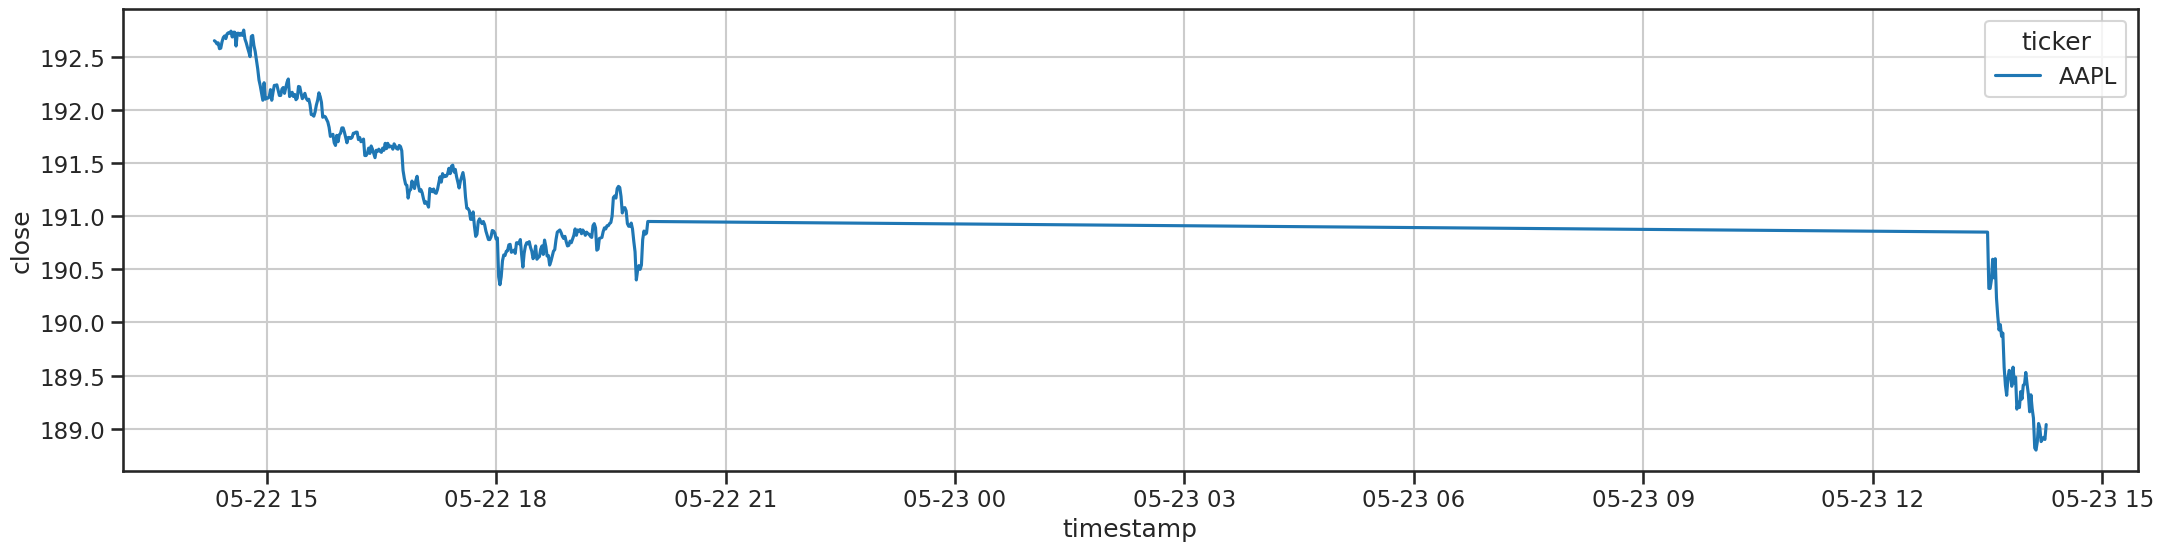

In [12]:
sns.set_context('talk')
# sns.set_palette('Pastel2')

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(26,6))

sns.set_style("ticks",{'axes.grid' : True})

ax = sns.lineplot(df.toPandas(), x="timestamp", y="close", hue="ticker")
